# Machine Learning in Python - Project 1

Due Friday, Feb 28th by 4 pm.

*Include contributors names in notebook metadata or here*

## Setup

*Install any packages here, define any functions if neeed, and load data*

In [1]:
# Add any additional libraries or submodules below

# Data libraries
import pandas as pd
import numpy as np

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting defaults
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 80

# sklearn modules
import sklearn
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, KFold

In [4]:
# helper function
def get_coefs(m):
    """Returns the model coefficients from a Scikit-learn model object as an array,
    includes the intercept if available. This function is extracted from workshop5 code.
    """
    
    # If pipeline, use the last step as the model
    if (isinstance(m, sklearn.pipeline.Pipeline)):
        m = m.steps[-1][1]
    
    
    if m.intercept_ is None:
        return m.coef_
    
    return np.concatenate([[m.intercept_], m.coef_])


def model_fit(m, X, y, plot = False):
    """Returns the mean squared error, root mean squared error and R^2 value of a fitted model based 
    on provided X and y values. This function is also extracted from workshop5 code.
    
    Args:
        m: sklearn model object
        X: model matrix to use for prediction
        y: outcome vector to use to calculating rmse and residuals
        plot: boolean value, should fit plots be shown 
    """
    
    y_hat = m.predict(X)
    MSE = mean_squared_error(y, y_hat)
    RMSE = np.sqrt(mean_squared_error(y, y_hat))
    Rsqr = r2_score(y, y_hat)
    
    Metrics = (round(MSE, 4), round(RMSE, 4), round(Rsqr, 4))
    
    res = pd.DataFrame(
        data = {'y': y, 'y_hat': y_hat, 'resid': y - y_hat}
    )
    
    if plot:
        plt.figure(figsize=(12, 6))
        
        plt.subplot(121)
        sns.lineplot(x='y', y='y_hat', color="grey", data =  pd.DataFrame(data={'y': [min(y),max(y)], 'y_hat': [min(y),max(y)]}))
        sns.scatterplot(x='y', y='y_hat', data=res).set_title("Observed vs Fitted values")
        
        plt.subplot(122)
        sns.scatterplot(x='y_hat', y='resid', data=res).set_title("Fitted values vs Residuals")
        plt.hlines(y=0, xmin=np.min(y), xmax=np.max(y), linestyles='dashed', alpha=0.3, colors="black")
        
        plt.subplots_adjust(left=0.0)
        
        plt.suptitle("Model (MSE, RMSE, Rsq) = " + str(Metrics), fontsize=14)
        plt.show()
    
    return MSE, RMSE, Rsqr

# Introduction

*This section should include a brief introduction to the task and the data (assume this is a report you are delivering to a professional body (e.g. Alzheimer's Association, Health Institutes and/or other Charities on dementia and ageing).*

*Briefly outline the approaches being used and the conclusions that you are able to draw.*

The original dataset contains several variables including:

(1) RID - person identifier;

(2) ADAS13.bl - ADAS-Cog 13 score at baseline. The Alzheimer’s Disease Assessment Scale-Cognitive Subscale (ADAS-Cog) 13 includes 13 tasks that assess memory, language, and praxis. Specific tasks include word recall, naming objects and fingers, commands, constructional praxis, ideational praxis, orientation, word recognition, language, delayed word recall and a number cancellation or maze task. ADAS-Cog-13 scores range from 0 to 85, with higher scores indicates worse cognitive impairment;

(3) ADAS13.m24 - ADAS-Cog 13 score at 24-month follow-up visit;

(4) AGE - age of the individual at the baseline visit;

(5) DX.bl - diagnosis of the individual at the baseline visit. The four categories (in increasing severeness) are cognitively normal (CN), early mild cognitive impairment (ECMI), late cognitive impairment (LCMI), and Alzheimer’s disease (AD);

(6) PTGENDER - gender of the individual (male or female);

(7) PTEDUCAT - number of years of education;

(8) PTETHCAT - ethnicity of the individual (three levels: not Hispanic/Latino, Hispanic/Latino, or unknown);

(9) PTRACCAT - race of the individual (7 levels: white, black, asian, american indian/alaskan, hawaiian/other pacific islands, more than one, unknown);

(10) PTMARRY - martial status at baseline;

(11) APOE4 - APOE genotype: indicates if the individual carries 0, 1, or 2 copies of the e4 allele;

(12) Ventricles - volume of the ventricles in cubic millimeters extracted from a magnetic resonance image at baseline;

(13) Hippocampus - volume of the hippocampus in cubic millimeters extracted from a magnetic
resonance image at baseline;

(14) WholeBrain - volume of the whole brain in cubic millimeters extracted from a magnetic
resonance image at baseline;

(15) Entorhinal - volume of the entorhinal cortex in cubic millimeters extracted from a magnetic resonance image at baseline;

(16) Fusiform - volume of the fusiform gyrus in cubic millimeters extracted from a magnetic
resonance image at baseline;

(17) MidTemp - volume of the middle temporal lobe in cubic millimeters extracted from a magnetic resonance image at baseline;

(18) ICV - intracranial volume in cubic millimeters extracted from a magnetic resonance image at baseline.

There are some remarks on these variables:

(1) The relation between ICV, Ventricles and WholeBrain is: ICV = Ventricles + WholeBrain;

(2) The hippocampus and entorhinal cortex are brain regions closely associated with memory function. Their atrophy may be linked to cognitive decline. These variables are likely to play a significant role in predicting ADAS13.m24 (cognitive score at the 24-month follow-up);

(3) A reduction in whole brain volume may indicate overall brain atrophy, which is correlated with cognitive decline.

Our goal is to build a predictive model to estimate the cognitive assessment score at the 24-month follow-up based on baseline characteristics, and then identify factors associated with cognitive decline risk and determine high-risk individuals who may benefit from early interventions or clinical trials.

We mainly applied EDA, feature engineering, LASSO, polynomial and XGBoost to conduct the linear regression.

# Exploratory Data Analysis and Feature Engineering

*Include a detailed discussion of the data with a particular emphasis on the features of the data that are relevant for the subsequent modeling. Including visualizations of the data is strongly encouraged - all code and plots must also be described in the write up. Think carefully about whether each plot needs to be included in your final draft and the appropriate type of plot and summary for each variable type - your report should include figures but they should be as focused and impactful as possible.*

*You should also split your data into training and testing sets, ideally before you look to much into the features and relationships with the target*

*Additionally, this section should also implement and describe any preprocessing / feature engineering of the data. Specifically, this should be any code that you use to generate new columns in the data frame `d`. Feature engineering that will be performed as part of an sklearn pipeline can be mentioned here but should be implemented in the following section.*

*All code and figures should be accompanied by text that provides an overview / context to what is being done or presented.*

In [ ]:
# Load the data.
d = pd.read_csv("adnidata.csv")
d.head()

In [ ]:
# For general info.
d.info()

# For the summary statistics.
d.describe()

In [5]:
# Deal with the missing values in the dataset.
# Here we fill in all the missing values with median of known values in every column.
# We use median because it is robust to outliers and very convenient to calculate. But it may damage the correlation between variables and thus leading to bias.
d.fillna(d.median(numeric_only=True), inplace=True)

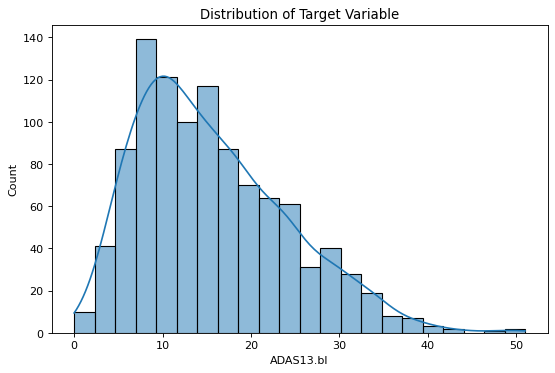

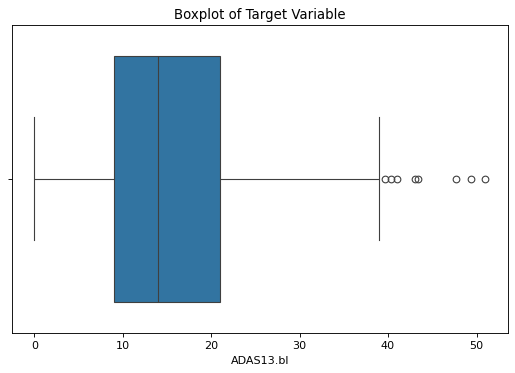

In [6]:
# We observed the distributions of all variables. Here we show the histogram and boxplot of one of these variable (ADAS13.bl).
sns.histplot(d['ADAS13.bl'], kde=True)
plt.title("Distribution of Target Variable")
plt.show()

sns.boxplot(x=d['ADAS13.bl'])
plt.title("Boxplot of Target Variable")
plt.show()


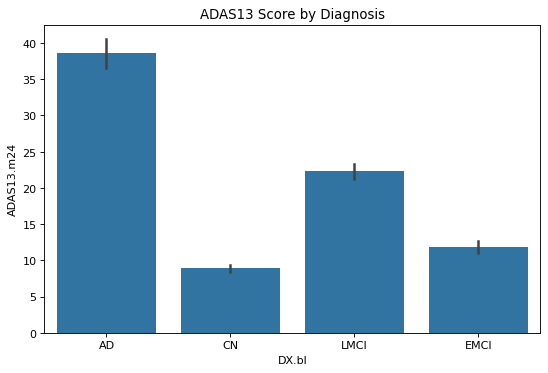

In [7]:
# We show the histogram of ADA513 scored by diagnosis.
sns.barplot(x='DX.bl', y='ADAS13.m24', data=d)
plt.title('ADAS13 Score by Diagnosis')
plt.show()

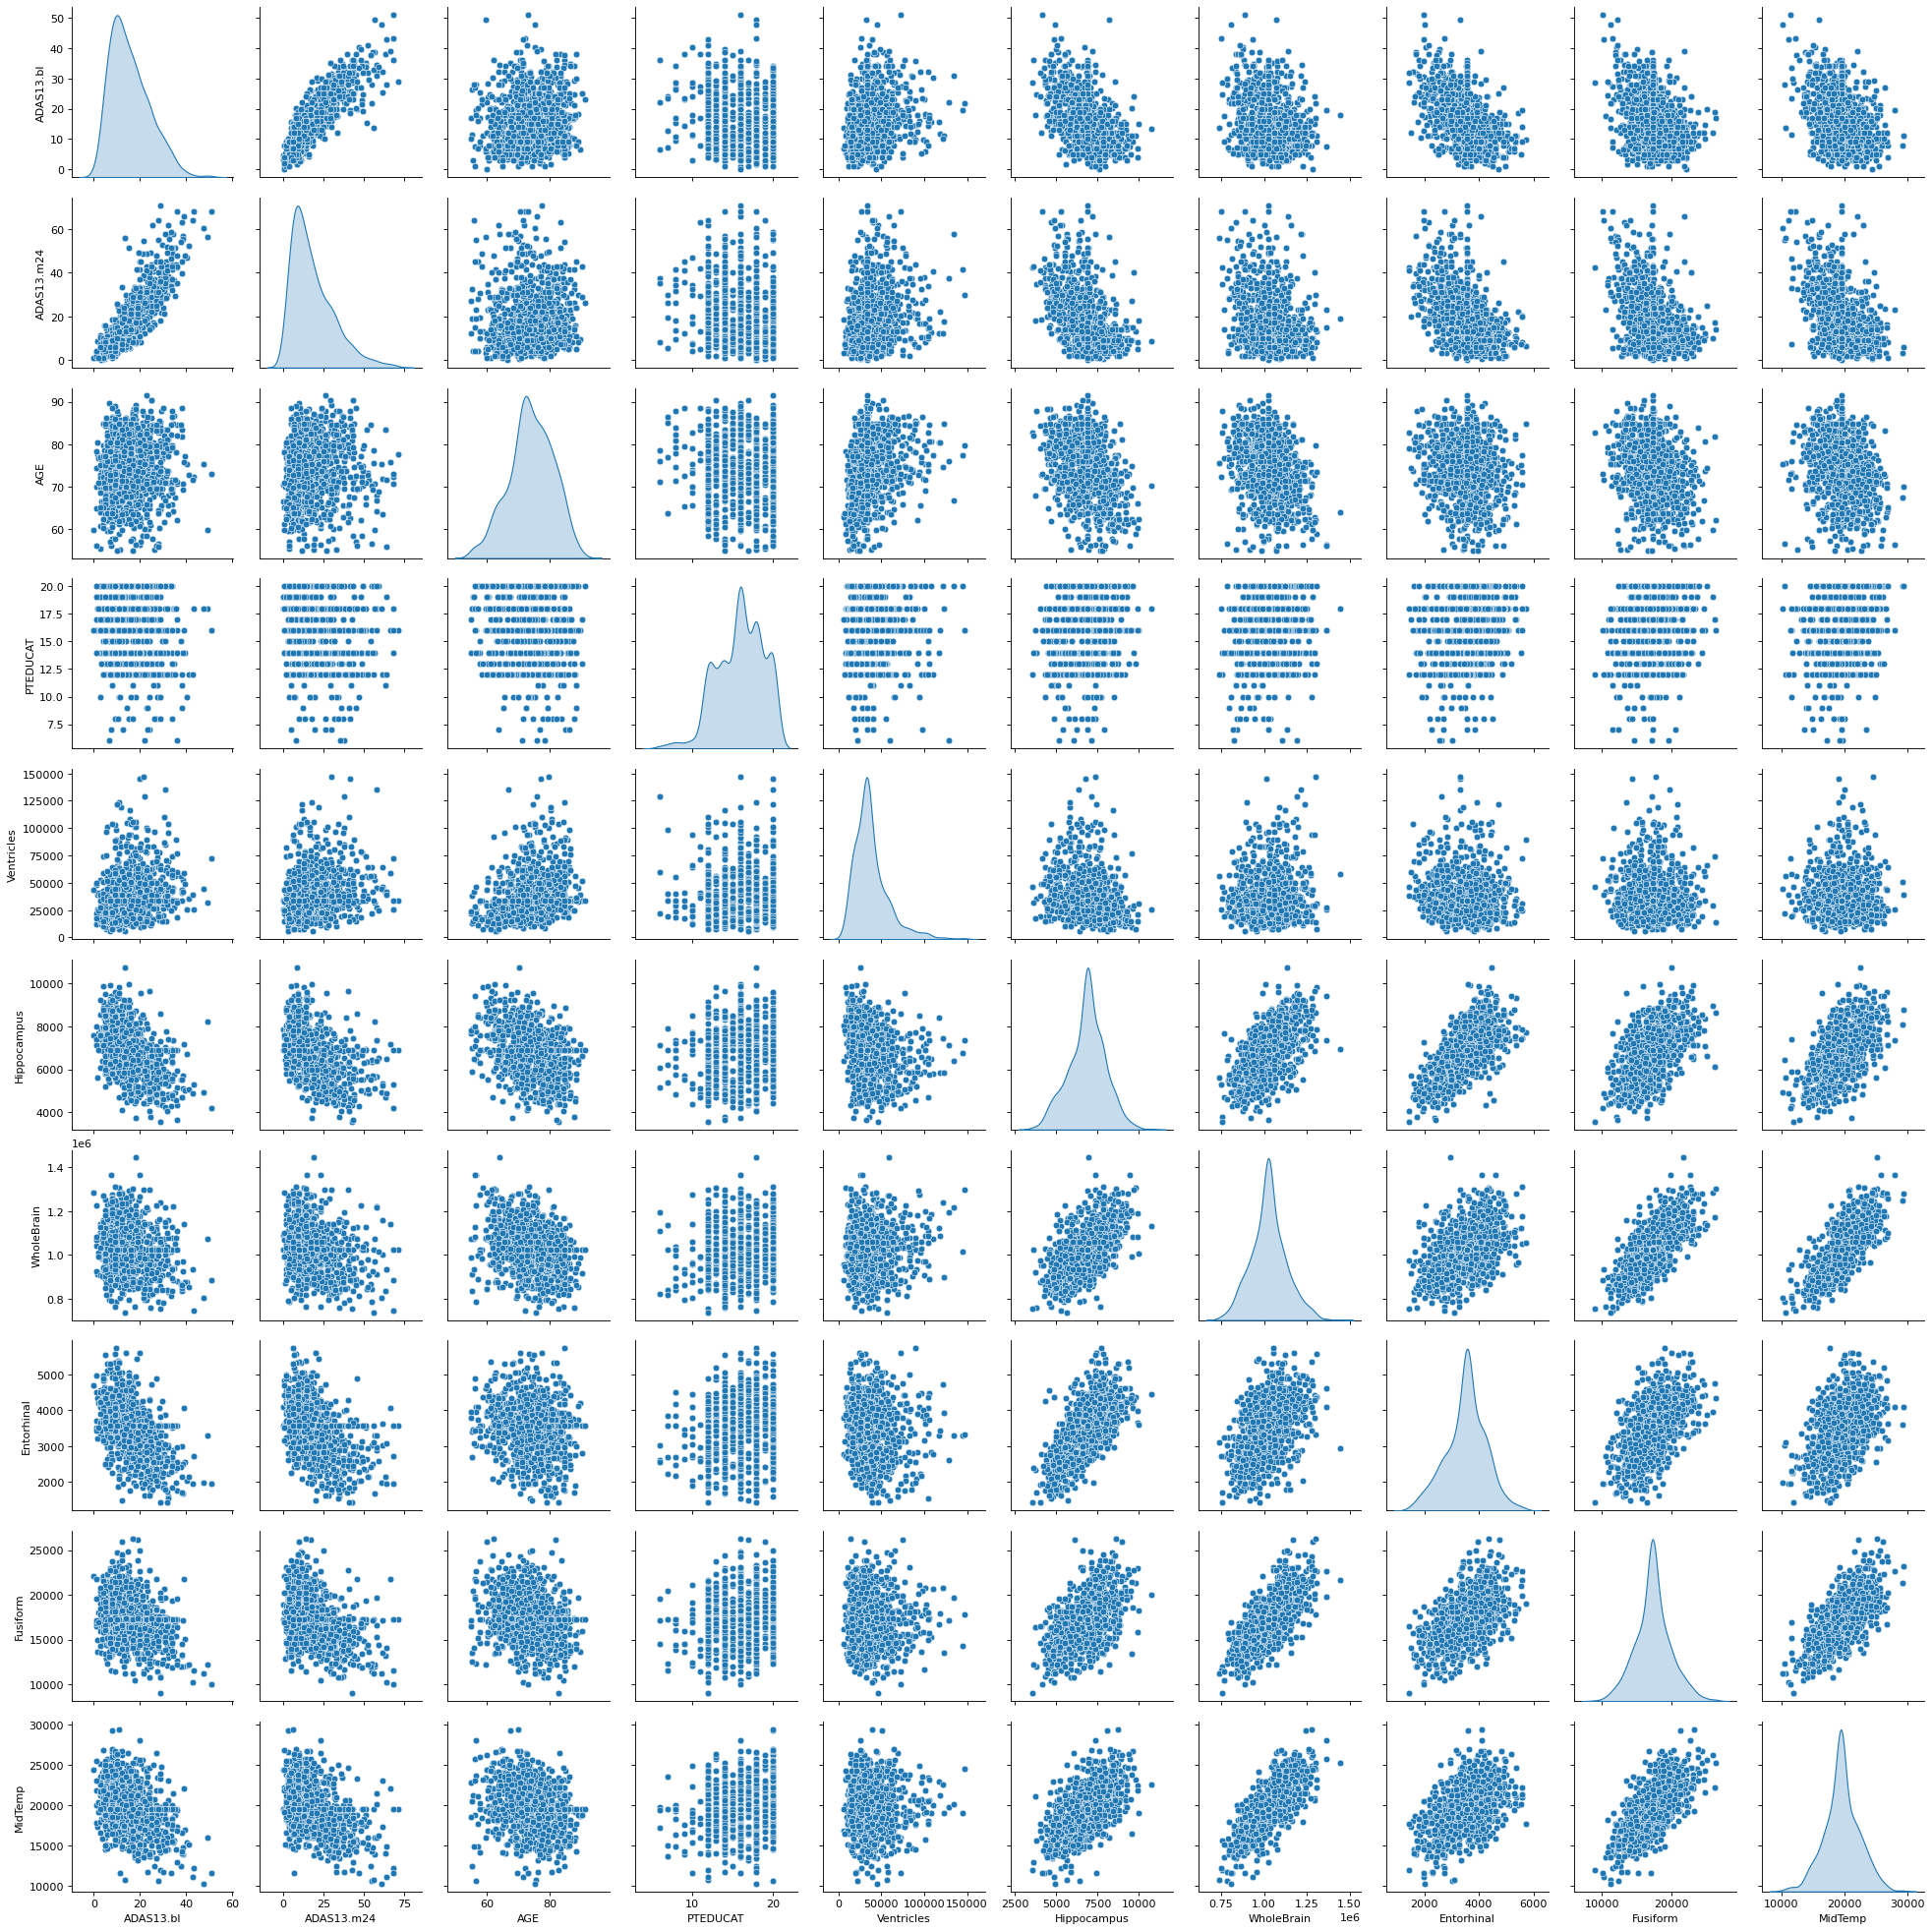

In [8]:
# Using pairplot to plot all numeric features.
sns.pairplot(d, vars= ['ADAS13.bl','ADAS13.m24','AGE','PTEDUCAT','Ventricles','Hippocampus','WholeBrain','Entorhinal','Fusiform','MidTemp'],diag_kind='kde')
plt.show()
# The plot at the diagonal shows the distribution of the valuables, while the rest plot shows the relation of 2 variables.

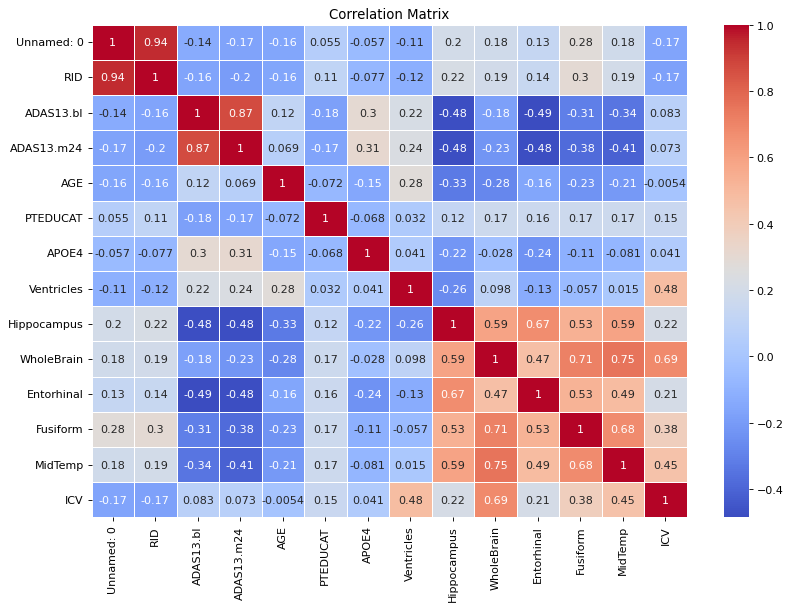

In [9]:
numeric_data = d.select_dtypes(include=['number'])

# Calculate the correlation metrix.
corr_matrix = numeric_data.corr()

# According to the correlation metrix, we plot the thermodynamic graph.
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()


By analyzing the data dictionary in the PDF, as well as the pair plot and heatmap, we conclude that RID and Unnamed: 0 are index variables and should not be used for model fitting. ADAS13.m24 is the target variable to be predicted and should also not be used as an input feature for the model.

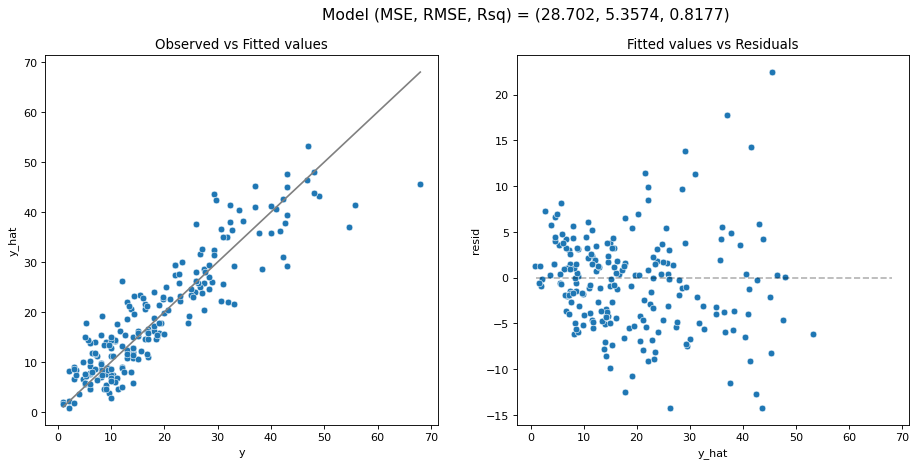

Index(['ADAS13.bl', 'AGE', 'PTEDUCAT', 'APOE4', 'Ventricles', 'Hippocampus',
       'WholeBrain', 'Entorhinal', 'Fusiform', 'MidTemp', 'ICV', 'DX.bl_CN',
       'DX.bl_EMCI', 'DX.bl_LMCI', 'PTGENDER_Male', 'PTMARRY_Married',
       'PTMARRY_Never married', 'PTMARRY_Unknown', 'PTMARRY_Widowed',
       'PTETHCAT_Not Hisp/Latino', 'PTETHCAT_Unknown', 'PTRACCAT_Asian',
       'PTRACCAT_Black', 'PTRACCAT_Hawaiian/Other PI',
       'PTRACCAT_More than one', 'PTRACCAT_Unknown', 'PTRACCAT_White'],
      dtype='object')


In [34]:
# Model 1: Apply linear regression model to the original dataset.
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso

# Read the data.
d = pd.read_csv("adnidata.csv")

# Fill in the missing data with the median in every column.
d.fillna(d.median(numeric_only=True), inplace=True)
# d.dropna(axis=1, inplace=True)


# Deal with the category variables by one-hot encoding.
# d = pd.get_dummies(d, columns=['DX.bl', 'APOE4','PTGENDER', 'PTMARRY', 'PTETHCAT', 'PTRACCAT'], drop_first=True)
d = pd.get_dummies(d, columns=['DX.bl','PTGENDER', 'PTMARRY', 'PTETHCAT', 'PTRACCAT'], drop_first=True)

# Here we can try target encoder.
# encoder = ce.TargetEncoder(cols=['DX.bl', 'PTMARRY', 'APOE4'])
# d_encoded = encoder.fit_transform(d, d['ADAS13.m24'])

# Choose the features and the target variables.
# features = ['ADAS13.bl','PTEDUCAT', 'AGE','Ventricles', 'Hippocampus', 'WholeBrain', 'Entorhinal', 'Fusiform', 'MidTemp', 'ICV']
features_todrop = ['Unnamed: 0','RID','ADAS13.m24']
features = [col for col in d.columns if col not in features_todrop]
X = d[features]
y = d['ADAS13.m24']

# Split the original data into training data and testing data.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the model.
model = LinearRegression()
model.fit(X_train, y_train)

model_fit(model,X_test,y_test,plot=True)
print(X.columns)

In [11]:
# Feature Engineer
# Select all the feature names for correlation calculation.
selected_features = ['ADAS13.bl','PTEDUCAT', 'AGE','APOE4','Ventricles', 'Hippocampus', 'WholeBrain', 'Entorhinal', 'Fusiform', 'MidTemp', 'ICV']

# Calculate the correlation between each selected feature and the target variable.
correlation_matrix = d[selected_features + ['ADAS13.m24']].corr()

# Extract the correlation between each selected feature and the target variable.
correlation_with_y = correlation_matrix['ADAS13.m24'].sort_values(ascending=False)

# Show the results.
print(correlation_with_y)


ADAS13.m24     1.000000
ADAS13.bl      0.866910
APOE4          0.313392
Ventricles     0.237050
ICV            0.072711
AGE            0.069437
PTEDUCAT      -0.165225
WholeBrain    -0.230552
Fusiform      -0.378886
MidTemp       -0.413917
Entorhinal    -0.475666
Hippocampus   -0.478414
Name: ADAS13.m24, dtype: float64


From model 1, we get MSE = 28.702, R_sq = 0.8177.

By observing the correlation between each selected features and the target variable, we find that AGE and PTEDUCAT have little impact on the target variable. We consider deleting these two variables when fitting the model.

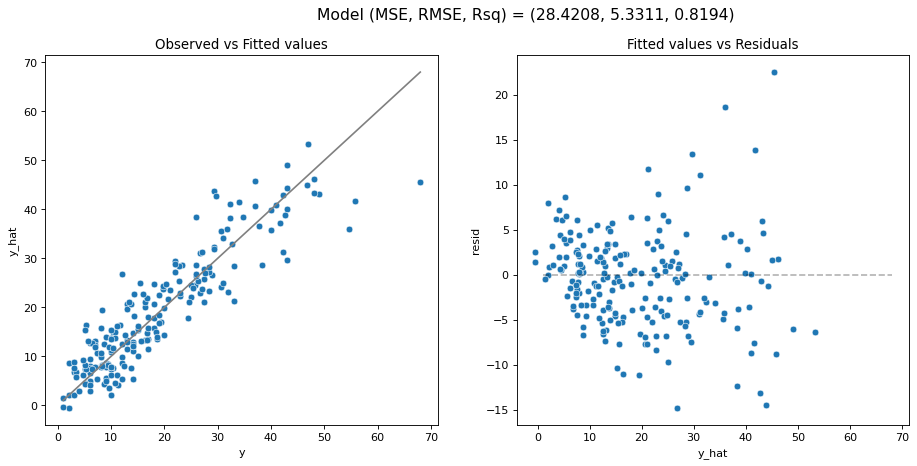

Index(['ADAS13.bl', 'APOE4', 'Ventricles', 'Hippocampus', 'WholeBrain',
       'Entorhinal', 'Fusiform', 'MidTemp', 'ICV', 'DX.bl_CN', 'DX.bl_EMCI',
       'DX.bl_LMCI', 'PTGENDER_Male', 'PTMARRY_Married',
       'PTMARRY_Never married', 'PTMARRY_Unknown', 'PTMARRY_Widowed',
       'PTETHCAT_Not Hisp/Latino', 'PTETHCAT_Unknown', 'PTRACCAT_Asian',
       'PTRACCAT_Black', 'PTRACCAT_Hawaiian/Other PI',
       'PTRACCAT_More than one', 'PTRACCAT_Unknown', 'PTRACCAT_White'],
      dtype='object')
(1038, 25)


In [35]:
# Model 2: Delete the variables with low correlation.
# Load the data.
d = pd.read_csv("adnidata.csv")

# Fill in the missing data with the median in every column.
d.fillna(d.median(numeric_only=True), inplace=True)

# Deal with the category variables by one-hot encoding.
d = pd.get_dummies(d, columns=['DX.bl','PTGENDER', 'PTMARRY', 'PTETHCAT', 'PTRACCAT'], drop_first=True)

# Delete these variables.
features_todrop = ['ADAS13.m24','AGE','PTEDUCAT','Unnamed: 0','RID']
features = [col for col in d.columns if col not in features_todrop]

# Create the new dataset.
X = d[features]

# Split the original data into training data and testing data.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the linear regression model.
model2 = LinearRegression()
model2.fit(X_train, y_train)

model_fit(model2,X_test,y_test,plot=True)
print(X.columns)
print(X.shape)

From model 2, we get MSE = 28.4208, and R_sq = 0.8194.

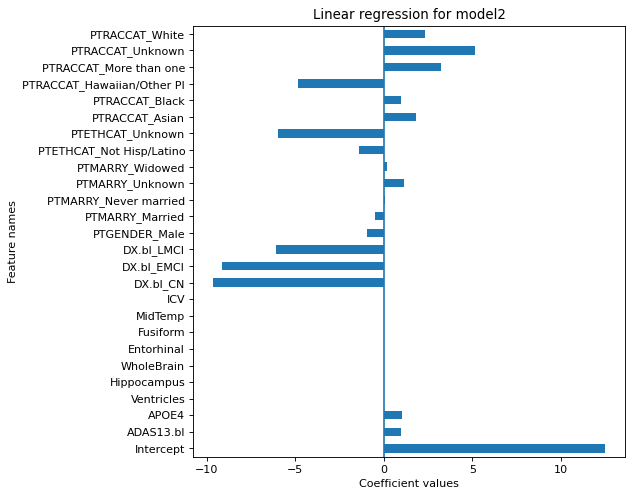

In [13]:
# Visualize Model 2 coefficients.
# Get the coefficients and organize them in a dataframe.
m2_coef = pd.DataFrame(get_coefs(model2), index=['Intercept'] + list(X.columns), columns=["Coefficient"])

# Plot the coefficients in a bar chart.
m2_coef.plot.barh(figsize=(9, 7), legend=False)
plt.title("Linear regression for model2")
plt.axvline(x=0)
plt.xlabel("Coefficient values")
plt.ylabel("Feature names")
plt.subplots_adjust(left=0.3)
plt.show()

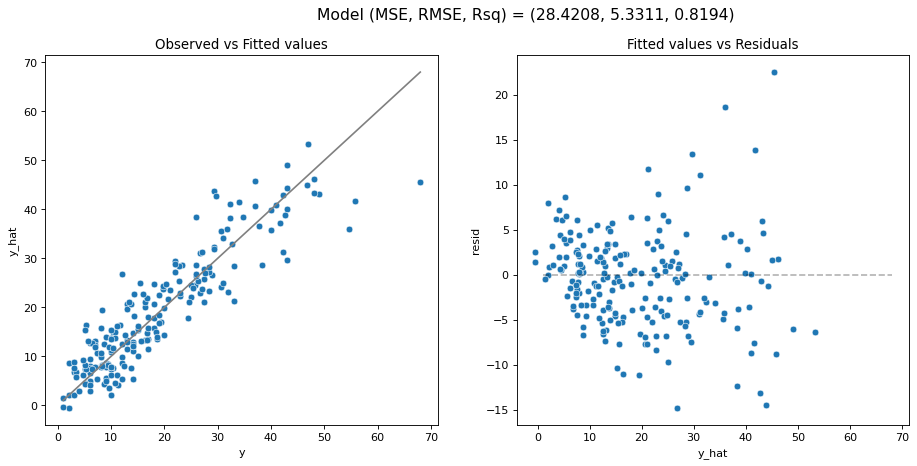

(28.420786810026033, 5.331114968749598, 0.8194474401237405)

In [36]:
# Model 3 Standard Scaling
from sklearn.preprocessing import StandardScaler

# Initialize the standard scaler.
scaler = StandardScaler()

# Standardize the feature variables.
X_scaled = scaler.fit_transform(X)

X_scaled_d = pd.DataFrame(X_scaled, columns=X.columns)

# Split the data into training data and testing data.
X_train, X_test, y_train, y_test = train_test_split(X_scaled_d, y, test_size=0.2, random_state=42)

# Initialize and train the model.
model3 = LinearRegression()
model3.fit(X_train, y_train)

model_fit(model3,X_test,y_test,plot=True)


From model 3, we get MSE = 28.4208, R_sq = 0.8194.

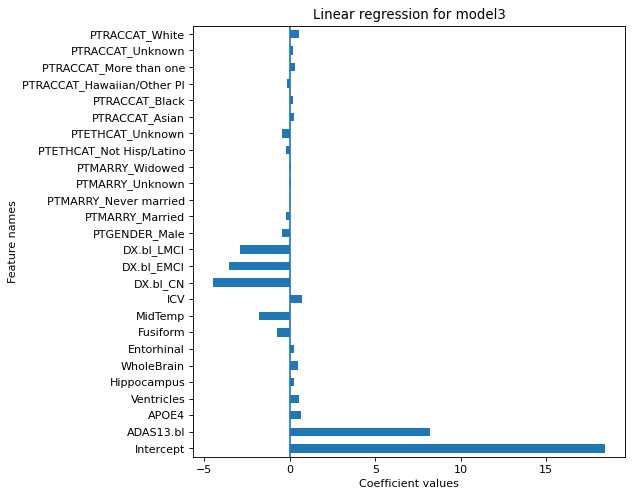

In [19]:
# Visualize Model 2 coefficients.
# Get the coefficients and organize them in a dataframe.
m3_coef = pd.DataFrame(get_coefs(model3), index=['Intercept'] + list(X.columns), columns=["Coefficient"])

# Plot the coefficients in a bar chart.
m3_coef.plot.barh(figsize=(9, 7), legend=False)
plt.title("Linear regression for model3")
plt.axvline(x=0)
plt.xlabel("Coefficient values")
plt.ylabel("Feature names")
plt.subplots_adjust(left=0.3)
plt.show()

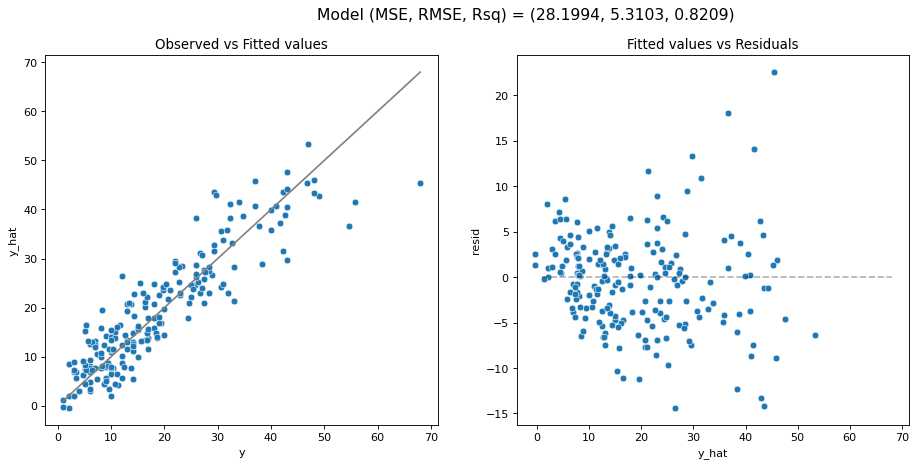

Index(['ADAS13.bl', 'APOE4', 'Ventricles', 'Hippocampus', 'WholeBrain',
       'Entorhinal', 'Fusiform', 'MidTemp', 'ICV', 'DX.bl_CN', 'DX.bl_EMCI',
       'DX.bl_LMCI', 'PTGENDER_Male', 'PTMARRY_Married',
       'PTMARRY_Never married', 'PTMARRY_Unknown', 'PTMARRY_Widowed',
       'PTETHCAT_Not Hisp/Latino', 'PTETHCAT_Unknown', 'PTRACCAT_Asian',
       'PTRACCAT_Black', 'PTRACCAT_Hawaiian/Other PI',
       'PTRACCAT_More than one', 'PTRACCAT_Unknown', 'PTRACCAT_White'],
      dtype='object')
(1038, 25)


In [37]:
# Model 4: We find that brain volume varies among individuals. Therefore, in the new model, we calculate the proportion of each brain region's volume relative to total brain volume to eliminate the error caused by individual differences. The model will be fitted using percentage-based values.

# Load the data.
d = pd.read_csv("adnidata.csv")

# Fill in the missing data with the median in every column.
d.fillna(d.median(numeric_only=True), inplace=True)

# Deal with the category variables by one-hot encoding.
d = pd.get_dummies(d, columns=['DX.bl','PTGENDER', 'PTMARRY', 'PTETHCAT', 'PTRACCAT'], drop_first=True)

# Calculate the proportion of brain volume and use percentages to reduce the differences in head size.
d['WholeBrain'] = d['WholeBrain'] / d['ICV']
d['Ventricles'] = d['Ventricles'] / d['ICV']
d['Hippocampus'] = d['Hippocampus'] / d['WholeBrain']
d['Entorhinal'] = d['Entorhinal'] / d['WholeBrain']
d['MidTemp'] = d['MidTemp'] / d['WholeBrain']
d['Fusiform'] = d['Fusiform'] / d['WholeBrain']

# Delete these variables.
features_todrop = ['ADAS13.m24','AGE','PTEDUCAT','Unnamed: 0','RID']
features = [col for col in d.columns if col not in features_todrop]

# Create the new dataset.
X = d[features]

# Split the original data into training data and testing data.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the linear regression model.
model4 = LinearRegression()
model4.fit(X_train, y_train)

model_fit(model4,X_test,y_test,plot=True)
print(X.columns)
print(X.shape)

After above, we have also tried polynomial regression and ridge regression, only to find they are not as efficient as the former models (the MSEs are higher and the R_sq values are lower. Finally, we decide to optimize the model with LASSO.

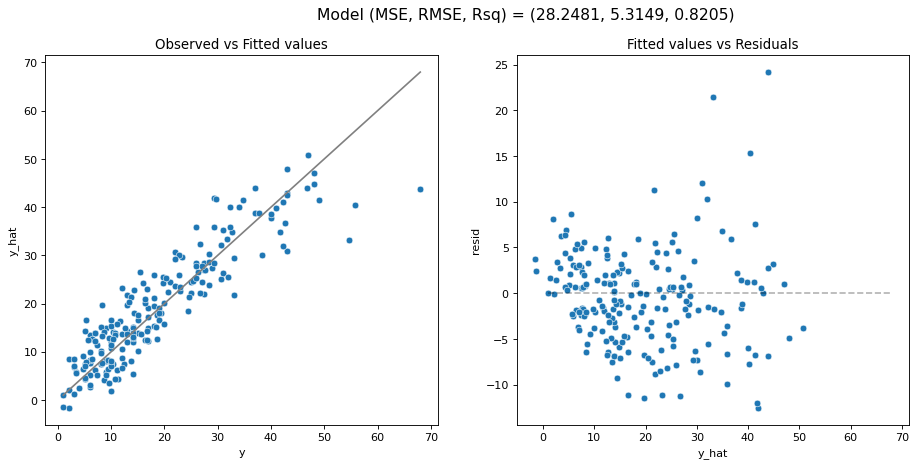

Index(['ADAS13.bl', 'APOE4', 'Ventricles', 'Hippocampus', 'WholeBrain',
       'Entorhinal', 'Fusiform', 'MidTemp', 'ICV', 'DX.bl_CN', 'DX.bl_EMCI',
       'DX.bl_LMCI', 'PTGENDER_Male', 'PTMARRY_Married',
       'PTMARRY_Never married', 'PTMARRY_Unknown', 'PTMARRY_Widowed',
       'PTETHCAT_Not Hisp/Latino', 'PTETHCAT_Unknown', 'PTRACCAT_Asian',
       'PTRACCAT_Black', 'PTRACCAT_Hawaiian/Other PI',
       'PTRACCAT_More than one', 'PTRACCAT_Unknown', 'PTRACCAT_White'],
      dtype='object')
(1038, 25)


In [61]:
# LASSO model: In this part we choose LASSO model instead of ordinary linear model. First, we do not standardize the feature variables in this model.
# We get MSE = 28.2481 and R_sq = 0.8205.

# Load the data.
d = pd.read_csv("adnidata.csv")

# Fill in the missing data with the median in every column.
d.fillna(d.median(numeric_only=True), inplace=True)

# Deal with the category variables by one-hot encoding.
d = pd.get_dummies(d, columns=['DX.bl','PTGENDER', 'PTMARRY', 'PTETHCAT', 'PTRACCAT'], drop_first=True)

# Delete these variables.
features_todrop = ['ADAS13.m24','AGE','PTEDUCAT','Unnamed: 0','RID']
features = [col for col in d.columns if col not in features_todrop]

# Create the new dataset.
X = d[features]

# Split the original data into training data and testing data.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the model.
lasso_model = Lasso(alpha=0.1)
lasso_model.fit(X_train, y_train)

model_fit(lasso_model,X_test,y_test,plot=True)
print(X.columns)
print(X.shape)

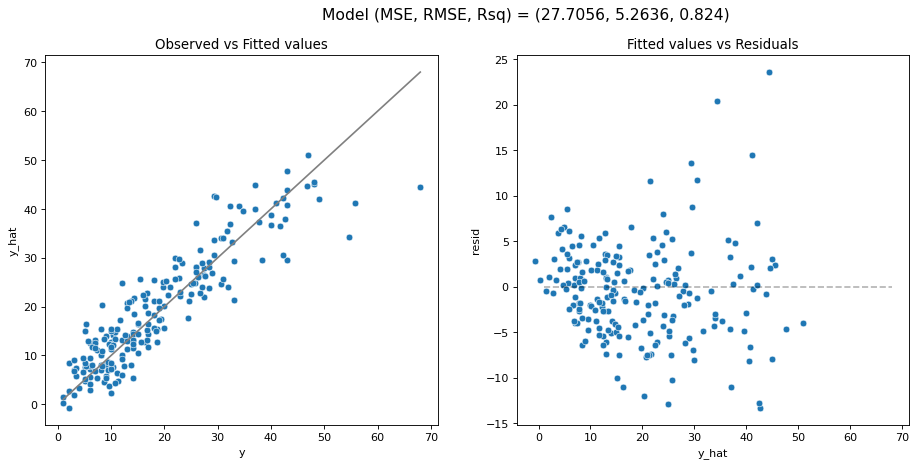

Index(['ADAS13.bl', 'APOE4', 'Ventricles', 'Hippocampus', 'WholeBrain',
       'Entorhinal', 'Fusiform', 'MidTemp', 'ICV', 'DX.bl_CN', 'DX.bl_EMCI',
       'DX.bl_LMCI', 'PTGENDER_Male', 'PTMARRY_Married',
       'PTMARRY_Never married', 'PTMARRY_Unknown', 'PTMARRY_Widowed',
       'PTETHCAT_Not Hisp/Latino', 'PTETHCAT_Unknown', 'PTRACCAT_Asian',
       'PTRACCAT_Black', 'PTRACCAT_Hawaiian/Other PI',
       'PTRACCAT_More than one', 'PTRACCAT_Unknown', 'PTRACCAT_White'],
      dtype='object')
(1038, 25)


/var/folders/86/bwh7hj0j55xb30z2hhwtdbcw0000gn/T/ipykernel_52095/2874548881.py:79: UserWarning: Glyph 23545 (\N{CJK UNIFIED IDEOGRAPH-5BF9}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/86/bwh7hj0j55xb30z2hhwtdbcw0000gn/T/ipykernel_52095/2874548881.py:79: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/86/bwh7hj0j55xb30z2hhwtdbcw0000gn/T/ipykernel_52095/2874548881.py:79: UserWarning: Glyph 21051 (\N{CJK UNIFIED IDEOGRAPH-523B}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/86/bwh7hj0j55xb30z2hhwtdbcw0000gn/T/ipykernel_52095/2874548881.py:79: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/86/bwh7hj0j55xb30z2hhwtdbcw0000gn/T/ipykernel_52095/2874548881.py:79: UserWarning: Glyph 19981 (\N{CJK UNIFIED IDEOGRAPH-4E0D}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/86/bwh7

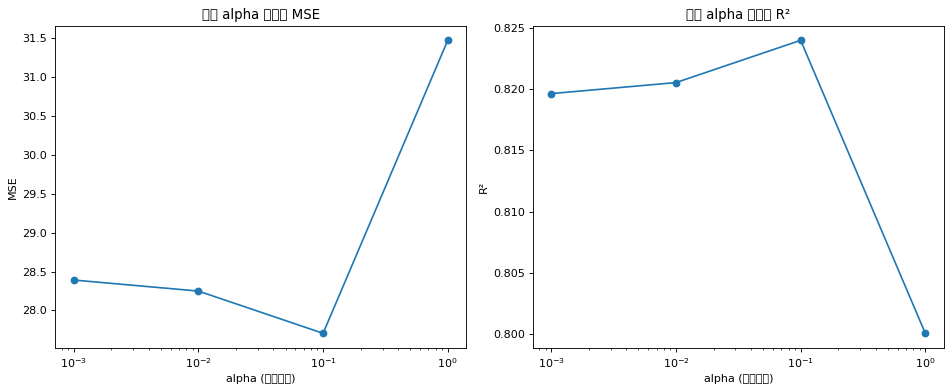

In [62]:
# Now we standardize the data in LASSO model this time.

# Load the data.
d = pd.read_csv("adnidata.csv")

# Fill in the missing data with the median in every column.
d.fillna(d.median(numeric_only=True), inplace=True)

# Deal with the category variables by one-hot encoding.
d = pd.get_dummies(d, columns=['DX.bl','PTGENDER', 'PTMARRY', 'PTETHCAT', 'PTRACCAT'], drop_first=True)

# Delete these variables.
features_todrop = ['ADAS13.m24','AGE','PTEDUCAT','Unnamed: 0','RID']
features = [col for col in d.columns if col not in features_todrop]

# Create new dataset.
X = d[features]

# Initialize the standard scaler.
scaler = StandardScaler()

# Standardize the feature variables.
X_scaled = scaler.fit_transform(X)
X_scaled_d = pd.DataFrame(X_scaled, columns=X.columns)

# Split the original data into training data and testing data.
X_train, X_test, y_train, y_test = train_test_split(X_scaled_d, y, test_size=0.2, random_state=42)

# Initialize and train the model.
lasso_model = Lasso(alpha=0.1)
lasso_model.fit(X_train, y_train)

model_fit(lasso_model,X_test,y_test,plot=True)
print(X.columns)
print(X.shape)

alphas = [0.001,0.01, 0.1, 1]

# Create 2 lists to store MSE and R_sq value corresponding to every alpha.
mse_list = []
r2_list = []

for alpha in alphas:
    lasso_model = Lasso(alpha=alpha)
    lasso_model.fit(X_train, y_train)
    
    # Prediction.
    y_pred = lasso_model.predict(X_test)
    
    # Calculate MSE and R_sq.
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Store the results in the lists.
    mse_list.append(mse)
    r2_list.append(r2)

# Visualize the data to make comparison.
plt.figure(figsize=(12,5))

# Subplot 1: MSE values under different alpha values.
plt.subplot(1, 2, 1)
plt.plot(alphas, mse_list, marker='o', linestyle='-')
plt.xscale('log')  # Use this code if observation on a logarithmic scale is needed.
plt.xlabel("alpha (log scale)")
plt.ylabel("MSE")
plt.title("MSE values under different alpha values")

# Subplot 2: R_sq values under different alpha values.
plt.subplot(1, 2, 2)
plt.plot(alphas, r2_list, marker='o', linestyle='-')
plt.xscale('log')  # Use this code if observation on a logarithmic scale is needed.
plt.xlabel("alpha (log scale)")
plt.ylabel("R_sq")
plt.title("R_sq values under different alpha values")

plt.tight_layout()
plt.show()

The last line charts above evidently shown the best alpha value is 0.1.

# Model Fitting and Tuning

*In this section you should detail your choice of model and describe the process used to refine, tune, and fit that model. You are strongly encouraged to explore different models (e.g. linear regression, interaction terms, lasso, etc.) but you should not include a detailed narrative of all of these attempts. At most this section should briefly mention the methods explored and why they were rejected - most of your effort should go into describing the model you are using and your process for tuning and validating it.*

*For example if you considered a linear regression model with interactions, a polynomial regression, and a lasso model and ultimately settled on the lasso approach then you should mention that other two approaches were tried but do not include any of the code or any in depth discussion of these models beyond why they were rejected. This section should then detail the development of the lasso model in terms of features used and additional tuning and validation which ultimately led to your final model.* 

*This section should also include the full implementation of your final model, including all necessary validation. As with figures, any included code must also be addressed in the text of the document.*

*Finally, you should also provide comparison of your model with baseline linear regression model on the test data but only briefly describe the baseline model considered*

# Discussion & Conclusions

*In this section you should provide a general overview of your final model, its performance, and reliability. You should discuss what the implications of your model are in terms of the included features, estimated parameters and relationships, predictive performance, and anything else you think is relevant.*

*This should be written with a target audience of a health official or charity director, who is understands the pressing challenges associated with ageining and dementia but may only have university level mathematics (not necessarily postgraduate statistics or machine learning). Your goal should be to highlight to this audience how your model can useful. You should also mention potential limitations of your model.*

*Finally, you should include recommendations on factors that may increase the risk of higher cognitive decline, which may be useful for identiying individuals that may benefit more from any proposed drugs or therapies.*

*Keep in mind that a negative result, i.e. a model that does not work well predictively, that is well explained and justified in terms of why it failed will likely receive higher marks than a model with strong predictive performance but with poor or incorrect explinations / justifications.*

We fitted the dataset using linear regression models and a LASSO model, obtaining the coefficients for features in each model. This allowed us to determine the relationship between each feature and the likelihood of developing Alzheimer's disease.

ADAS-Cog 13 score at baseline (ADAS13.bl) is the strongest predictor: Higher initial cognitive impairment increases the risk of Alzheimer’s.

Brain structure matters: Larger brain volumes, particularly in key regions like the hippocampus and entorhinal cortex, are associated with lower risk.

Demographics play a role: Gender, race, and marital status may influence risk, but further investigation is needed to determine causation.

ICV (total brain volume) appears protective, reinforcing the importance of structural brain integrity in resisting cognitive decline.

# Generative AI statement

*Include a statement on how generative AI was used in the project and report.*

In this project, we use generative AI to help us modify and improve the Python codes written by ourselves in order to make them work fluently. Besides, AI is also used to correct expression errors in code explanations and text reports put in the Markdown blocks, since our first language is not English, and thus we may inevitably make some grammatical and spelling errors.

# References

*Include references if any*

In [54]:
# Run the following to render to PDF
!jupyter nbconvert --to pdf project1.ipynb

[NbConvertApp] Converting notebook project1.ipynb to pdf
[NbConvertApp] ERROR | Error while converting 'project1.ipynb'
Traceback (most recent call last):
  File "/home/codespace/.local/lib/python3.12/site-packages/nbconvert/nbconvertapp.py", line 487, in export_single_notebook
    output, resources = self.exporter.from_filename(
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/codespace/.local/lib/python3.12/site-packages/nbconvert/exporters/templateexporter.py", line 386, in from_filename
    return super().from_filename(filename, resources, **kw)  # type:ignore[return-value]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/codespace/.local/lib/python3.12/site-packages/nbconvert/exporters/exporter.py", line 201, in from_filename
    return self.from_file(f, resources=resources, **kw)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/codespace/.local/lib/python3.12/site-packages/nbconvert/exporters/templateexporter.py", li